<a href="https://colab.research.google.com/github/thisyilife/Rock_Paper_Scissor_Detector/blob/main/RPS_handDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# User guide


1/ Choose which dataset will be used, imported or created one, in the code just below

2/ Choose which if you want to play the live version with webcam or the version using a button between each round, still in the code just below

3/ Select "execute all" in the top menu and follow the program comments to understand the applciation and see the results

4/ To pass to the section 7 it is mandatory to click on the webcam display to interrupt the execution of this part

Choose the options you want for the application

In [ ]:
# 0 for imported CGI dataset, 1 for our own dataset
ds_used = 0;

# 0 for live version, 1 for predict button 
version = 0;

## 1 - Import the necessary library for our prediction model

Google colabotary runtime can be changed to GPU, should needed.

In [ ]:
import numpy as np
import sys
import tensorflow as tf
import re
import random
import tensorflow_datasets.public_api as tfds
import os, glob, cv2
import urllib.request
import matplotlib.pyplot as plt

print("Python version : " + sys.version)
print("TensorFlow version : " + tf.__version__)

Python version : 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
TensorFlow version : 2.4.0


#### - Download the files containing hand gestures
 

In [ ]:
#Link to download the training dataset
if not(os.path.isfile('rps.zip')):
  !wget https://storage.googleapis.com/download.tensorflow.org/data/rps.zip

#Link to download the testing dataset
if not(os.path.isfile('rps-test-set.zip')):
  !wget https://storage.googleapis.com/download.tensorflow.org/data/rps-test-set.zip

#Cloning repository containing our own dataset
if not(os.path.isfile('rock_paper_scissors/image_data.zip')):
  !git clone https://github.com/nbrochar/rock_paper_scissors

#Link to download images to display computer move
if not(os.path.isfile('scissors.png')):
  !wget https://raw.githubusercontent.com/SouravJohar/rock-paper-scissors/master/images/scissors.png

if not(os.path.isfile('paper.png')):
  !wget https://raw.githubusercontent.com/SouravJohar/rock-paper-scissors/master/images/paper.png

if not(os.path.isfile('rock.png')):
  !wget https://raw.githubusercontent.com/SouravJohar/rock-paper-scissors/master/images/rock.png

--2021-01-21 19:07:20--  https://storage.googleapis.com/download.tensorflow.org/data/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.128, 172.217.2.112, 142.250.73.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘rps.zip’

rps.zip             100%[===================>] 191.38M   189MB/s    in 1.0s    

2021-01-21 19:07:21 (189 MB/s) - ‘rps.zip’ saved [200682221/200682221]

--2021-01-21 19:07:21--  https://storage.googleapis.com/download.tensorflow.org/data/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.9.208, 172.253.62.128, 172.217.15.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.9.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘rps-test-set.zip’

rps-te

### After Downloading, we extract the files in a temporary google folders.
---
Every files is already sorted in a folder following their gesture. Every files has a 300x300 size.
For example, a 'rock' for training is saved in as followed :

"./content/rps/rock/name.png"





In [ ]:
# Unzipping the training dataset
if not(os.path.exists('rps')):
  !unzip rps.zip;

# Unzipping the testing dataset
if not(os.path.exists('rps-test-set')):
  !unzip rps-test-set.zip; 

# Unzipping our own dataset
if not(os.path.exists('/content/image_data')):
  !unzip /content/rock_paper_scissors/image_data.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: rps/rock/rock01-062.png  
  inflating: rps/rock/rock01-063.png  
  inflating: rps/rock/rock01-064.png  
  inflating: rps/rock/rock01-065.png  
  inflating: rps/rock/rock01-066.png  
  inflating: rps/rock/rock01-067.png  
  inflating: rps/rock/rock01-068.png  
  inflating: rps/rock/rock01-069.png  
  inflating: rps/rock/rock01-070.png  
  inflating: rps/rock/rock01-071.png  
  inflating: rps/rock/rock01-072.png  
  inflating: rps/rock/rock01-073.png  
  inflating: rps/rock/rock01-074.png  
  inflating: rps/rock/rock01-075.png  
  inflating: rps/rock/rock01-076.png  
  inflating: rps/rock/rock01-077.png  
  inflating: rps/rock/rock01-078.png  
  inflating: rps/rock/rock01-079.png  
  inflating: rps/rock/rock01-080.png  
  inflating: rps/rock/rock01-081.png  
  inflating: rps/rock/rock01-082.png  
  inflating: rps/rock/rock01-083.png  
  inflating: rps/rock/rock01-084.png  
  inflating: rps/rock/roc

##2 - Create the structure for our dataset

In this part, we create the class_map with respect to the different hand gesture. The downloaded files are then loaded using tensorflow preprocessing functions. Grayscale is used because the skin's colour should not be taken account in our predictor.

In [ ]:
class_map = {
    "paper" : 0,
    "rock" : 1,
    "scissors" : 2
}

batch_size = 32
img_height = 300
img_width = 300

#Load images in gray level with the same seed in order to get the same shuffling
#The dataset that will be used for training in our CNN
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/rps',
  validation_split=0.2,
  subset="training",
  color_mode="grayscale",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#The dataset that will be used as a validation datatest in our CNN
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/rps',
  validation_split=0.2,
  subset="validation",
  color_mode="grayscale",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#The dataset used to predict after training completion
test_images = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/rps-test-set',
    validation_split=None,
    color_mode="grayscale",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
);

class_names = train_ds.class_names;
print(class_names)

Found 2520 files belonging to 3 classes.
Using 2016 files for training.
Found 2520 files belonging to 3 classes.
Using 504 files for validation.
Found 372 files belonging to 3 classes.
['paper', 'rock', 'scissors']


With this configuration, train_ds contains 80% of the first downloaded file while val_ds contains 20%. The parameter 'subset' and using the same seed in the *image_dataset_from_directory* function, allow the splitting of data to be done correctly.



---



Same operation for our own dataset

In [ ]:
train_perso_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/image_data',
  validation_split=0.2,
  subset="training",
  color_mode="grayscale",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

validation_perso_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/image_data',
  validation_split=0.2,
  subset="validation",
  color_mode="grayscale",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

class_names = train_perso_ds.class_names
print(class_names)

Found 3000 files belonging to 3 classes.
Using 2400 files for training.
Found 3000 files belonging to 3 classes.
Using 600 files for validation.
['paper', 'rock', 'scissors']


Now we can print some datas from both testing sets 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


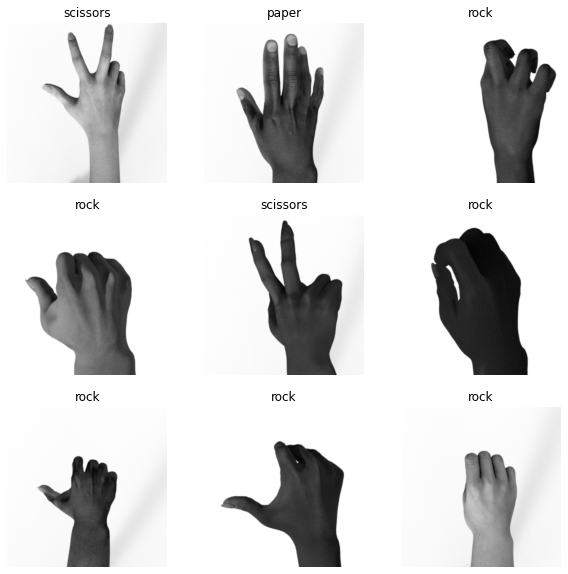

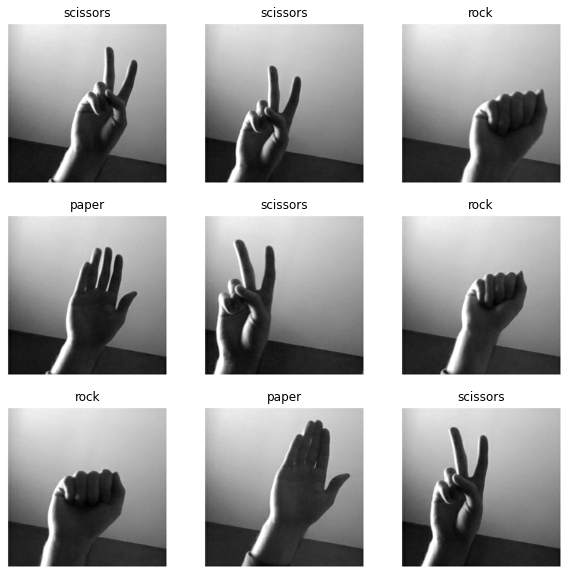

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(10):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    print_img = images[i][:,:,0]
    plt.imshow(print_img, cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.figure(figsize=(10, 10))
for images, labels in train_perso_ds.take(10):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    print_img = images[i][:,:,0]
    plt.imshow(print_img, cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")


## 3 - Creation of our Predictor model

In [ ]:
#Importation of some tensorflow functions and structures

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense
from tensorflow import keras

In [ ]:
#Choose which dataset will be used
if not ds_used:
  ds = train_ds;
  val_ds = validation_ds;
else:
  ds = train_perso_ds;
  val_ds = validation_perso_ds;

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

ds = ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
ds = ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Default parameter with our best found model

def build_model(i = 2, j = 2, k = 1, l = 64):
  input_shape = (300,300,1)
  model = models.Sequential();
  normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
  num_classes = 3;

  data_augmentation = keras.Sequential(
    [
      layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=input_shape),
      layers.experimental.preprocessing.RandomRotation((-0.2, 0.2)),
      layers.experimental.preprocessing.RandomZoom((-0.2,0.2)),
    ]
  )

  model.add(data_augmentation)
  model.add(normalization_layer)
  for n in range(i):
    model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  for n in range(j):
    model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  for n in range(k):
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(l, activation='relu'))
  model.add(layers.Dense(num_classes, name='predictions'))
  return model

Spacing if needing to use every model in our code

In [ ]:
model = build_model();
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 300, 300, 1)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 300, 300, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 32)      9

## 4 - Training steps

In [ ]:
# Compiling with our best found optimizer
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'] )
history = model.fit(ds, epochs=15, validation_data=val_ds,verbose=2) 

Epoch 1/15
63/63 - 24s - loss: 1.1050 - accuracy: 0.3378 - val_loss: 1.0955 - val_accuracy: 0.4722
Epoch 2/15
63/63 - 11s - loss: 0.9175 - accuracy: 0.5392 - val_loss: 0.4856 - val_accuracy: 0.7798
Epoch 3/15
63/63 - 12s - loss: 0.6271 - accuracy: 0.7302 - val_loss: 0.4063 - val_accuracy: 0.7976
Epoch 4/15
63/63 - 12s - loss: 0.3711 - accuracy: 0.8562 - val_loss: 0.2345 - val_accuracy: 0.8849
Epoch 5/15
63/63 - 12s - loss: 0.2355 - accuracy: 0.9196 - val_loss: 0.1426 - val_accuracy: 0.9643
Epoch 6/15
63/63 - 12s - loss: 0.1819 - accuracy: 0.9410 - val_loss: 0.1316 - val_accuracy: 0.9563
Epoch 7/15
63/63 - 12s - loss: 0.1386 - accuracy: 0.9494 - val_loss: 0.0576 - val_accuracy: 0.9821
Epoch 8/15
63/63 - 12s - loss: 0.0999 - accuracy: 0.9678 - val_loss: 0.0235 - val_accuracy: 0.9921
Epoch 9/15
63/63 - 11s - loss: 0.0875 - accuracy: 0.9717 - val_loss: 0.1008 - val_accuracy: 0.9722
Epoch 10/15
63/63 - 12s - loss: 0.0796 - accuracy: 0.9732 - val_loss: 0.0467 - val_accuracy: 0.9861
Epoch 11/

## Plotting the result training with matplot lib

Shows some prediction on several images took randomly among the testing set 

Also shows the general accuracy of the network on all the images of the testing set

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


12/12 [==============================] - 2s 83ms/step - loss: 0.0308 - accuracy: 0.9919


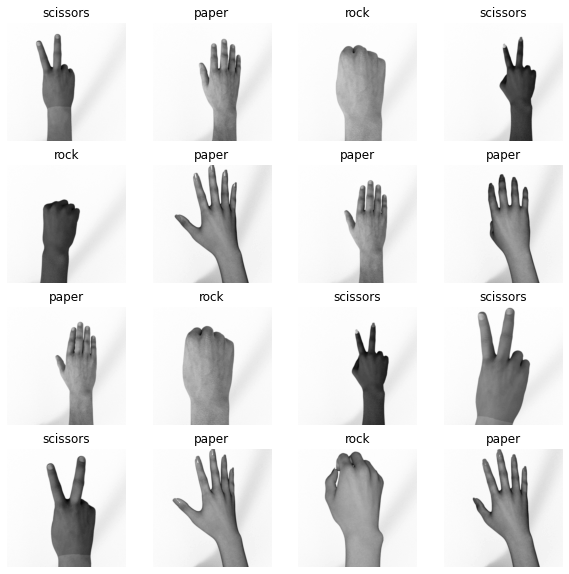

In [ ]:
predictData = test_images;

plt.figure(figsize=(10, 10))
for images, labels in predictData.take(10):
  predictions = model.predict(images)
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    print_img = images[i][:,:,0]
    plt.imshow(print_img, cmap='gray')
    plt.title(class_names[np.argmax(predictions[i])])
    plt.axis("off")

test_loss, test_acc = model.evaluate(predictData, verbose = 1)

Plotting with matplot lib for a more visual appealing effect

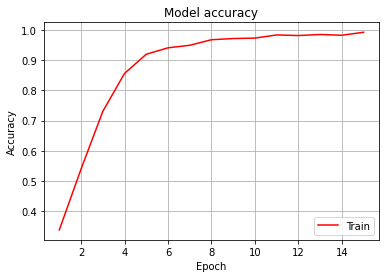

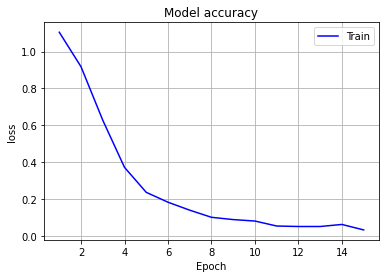

In [ ]:
plt.plot(list(range(1,len(history.history['accuracy'])+1)),history.history['accuracy'],'r')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(('Train', 'Validation', 'Test'), loc='lower right')
plt.grid()
plt.show()
plt.plot(list(range(1,len(history.history['loss'])+1)),history.history['loss'],'b')
plt.title('Model accuracy')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(('Train', 'Validation', 'Test'), loc='upper right')
plt.grid()
plt.show()

### - Confusion Matrix Test


In [ ]:
!pip install scikit-plot

In [ ]:
from keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np
from scikitplot.metrics import confusion_matrix, plot_confusion_matrix

nb_classes = 3;

['paper', 'rock', 'scissors']
 ------------------ CONFUSION MATRIX ------------------
[[101   0   3]
 [  0 107   0]
 [  0   0 109]]
Prediction obtained with confusion Matrix : 0.990625


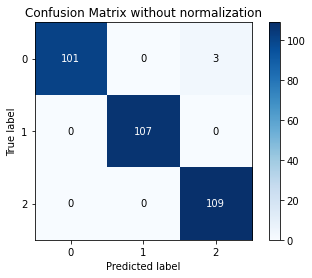

In [ ]:

test_prediction = test_images
predicted_class = []
true_class = []
nb_iter = 0;
pred = 0;
sum = int(0)

for images, labels in test_prediction.take(10):
  predictions = model.predict(images)
  #for i in range(16):
  #ax = plt.subplot(4, 4, i + 1)
  #print_img = images[i][:,:,0]
  for i in range(32):
    predicted_class.append(np.argmax(predictions[i]))
    true_class.append(labels[i])

print(class_names)

#Create a confusion matrix following the class_names order



print(" ------------------ CONFUSION MATRIX ------------------")
c_matrix = confusion_matrix(true_class, predicted_class)
print(c_matrix)
plot_confusion_matrix(true_class,
                      predicted_class,
                      title="Confusion Matrix without normalization")


#Compute accuracy obtained with confusion matrix
for i,j,k in c_matrix : 
  sum = sum + int(i) + int(j) + int(k) 
  if(nb_iter == 0):
    pred = pred + i
  if(nb_iter == 1):
    pred = pred + j
  if(nb_iter == 2):
    pred = pred + k
  nb_iter = nb_iter + 1;

print("Prediction obtained with confusion Matrix : " + str(pred/sum))
  

## 5 - Test with real images

The images are uploaded from a member's github. These are custom images cropped from shutterstock images. 

In [ ]:
!git clone https://github.com/thisyilife/hand_dataset.git

Cloning into 'hand_dataset'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 1), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [ ]:
#Unzip file
if not(os.path.exists('hands')):
  !unzip hand_dataset/hands.zip

Archive:  hand_dataset/hands.zip
   creating: hands/
  inflating: hands/paper.jpg         
  inflating: hands/paper1.png        
  inflating: hands/rock1.png         
  inflating: hands/scissor.jpg       
  inflating: hands/scissor.png       
  inflating: hands/black_font_scissor.png  
  inflating: hands/green_font.png    
  inflating: hands/green_rock.png    
  inflating: hands/green_scissor.png  


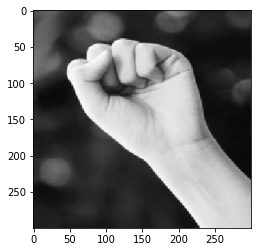

Predicted gesture : paper
----------------------------------------------------------


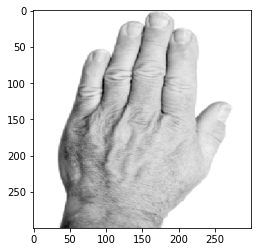

Predicted gesture : rock
----------------------------------------------------------


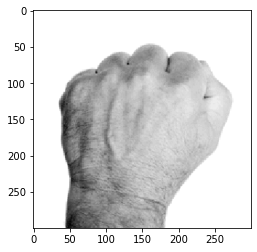

Predicted gesture : rock
----------------------------------------------------------


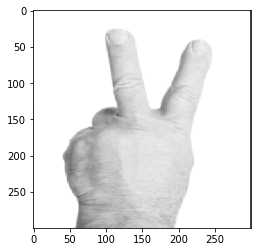

Predicted gesture : rock
----------------------------------------------------------


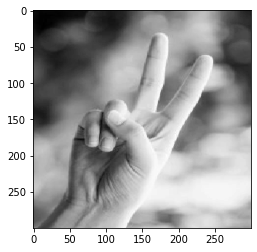

Predicted gesture : scissors
----------------------------------------------------------


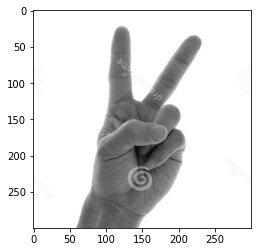

Predicted gesture : scissors
----------------------------------------------------------


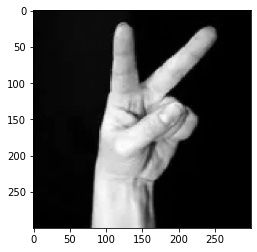

Predicted gesture : scissors
----------------------------------------------------------


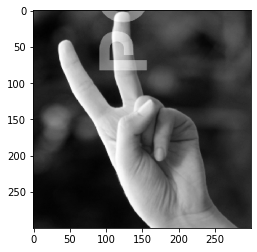

Predicted gesture : paper
----------------------------------------------------------


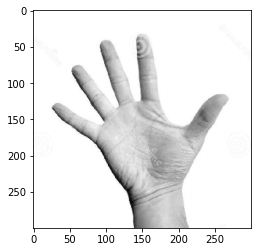

Predicted gesture : paper
----------------------------------------------------------


In [ ]:
#Path and array to store images
path = "/content/hands/"
p_img = [];

for f in glob.glob(os.path.join(path,'*')):
  img = keras.preprocessing.image.load_img(
      f, target_size=(img_height,img_width),color_mode='grayscale'
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)
  prediction = model.predict(img_array);
  p_img.append(img_array)
  plt.figure()
  plt.imshow(img, cmap = 'gray')
  plt.show()
  print("Predicted gesture : " + str(class_names[np.argmax(prediction)]))
  print("----------------------------------------------------------")

Add some Gaussian Noise in our predictor if we have time.

## 6 - Playing against the AI with Webcam

Since google colab is "online running" we need to use Javascript to create a webcam stream.

We add on overlay displaying boxes, for the use to put his hand and shows the move he wants to play and to show the move of the computer selected randomly then we show the winner of the round.

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

### Helper functions to handle javascript conversion

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    var capture;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      capture = document.createElement('button');
      capture.textContent = 'Prediction'
      div.appendChild(capture);

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }

    async function takePrediction() {
        await new Promise((resolve) => capture.onclick = resolve);
        return true;
    }

    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

def take_pred():
  data = eval_js('takePrediction()')
  return data;

## Playing against the computer

**A Camera is needed to use this part of the code.**

2 choices : 
- live version : playing in real time the computer detect each new different move
- predict buttton version : press the button to launch the round 

In [ ]:
from keras.models import load_model
from random import choice
from google.colab.patches import cv2_imshow

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
prev_move = None

def calculate_winner(move1, move2):
    if move1 == move2:
        return "Tie"

    if move1 == "rock":
        if move2 == "scissors":
            return "User"
        if move2 == "paper":
            return "Computer"

    if move1 == "paper":
        if move2 == "rock":
            return "User"
        if move2 == "scissors":
            return "Computer"

    if move1 == "scissors":
        if move2 == "paper":
            return "User"
        if move2 == "rock":
            return "Computer"

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])
  
    # grayscale image for face detection
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # extract the region of image within the user rectangle
    user_box = img[80:280, 100:300]
    img = cv2.resize(user_box, (img_height, img_width))

    # pre processing to feed the model
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    ##############       Live version       ##############
    if not version :
      prediction = model.predict(img_array)
      user_move_name = class_names[np.argmax(prediction)]
      if prev_move!= user_move_name:    
        computer_move_name = choice(['rock','scissors','paper'])
        winner = calculate_winner(user_move_name, computer_move_name)
      prev_move = user_move_name

    ##############  Predict button version  ##############
    else :
      requestPrediction = take_pred();
      if requestPrediction:    
        prediction = model.predict(img_array)
        user_move_name = class_names[np.argmax(prediction)]
        computer_move_name = choice(['rock','scissors','paper'])
        winner = calculate_winner(user_move_name, computer_move_name)
        requestPrediction = False;

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    # rectangle for user to play
    bbox_array = cv2.rectangle(bbox_array, (80, 100), (280, 300), (255, 255, 255), 2)
    # rectangle for computer to play
    bbox_array = cv2.rectangle(bbox_array, (360, 100), (560, 300), (255, 255, 255), 2)
    # texts for indication boxes
    bbox_array = cv2.putText(bbox_array, 
                        "Your Move: " +user_move_name,
                        (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        (255, 255, 255), 2)
    bbox_array = cv2.putText(bbox_array, "Computer's Move: " +computer_move_name,
                        (360, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        (255, 255, 255), 2)
    # winner text
    bbox_array = cv2.putText(bbox_array, "Winner: " +winner,
                        (200, 380), cv2.FONT_HERSHEY_SIMPLEX, 1,
                        (255, 255, 255), 2)
    
    # draw computer move icon 
    icon = cv2.imread("/content/{}.png".format(computer_move_name),-1)
    icon = cv2.resize(icon, (198, 198))
    bbox_array[101:299, 361:559] = icon

    # convert overlay of bbox into bytes
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255   
    bbox_bytes = bbox_to_bytes(bbox_array)
    
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

MessageError: ignored

## 7 - Parameters test code sample

#### Test with multiple optimizer to find the best one.

We test every possible optimizer and then plot the result to find the best one


In [ ]:
optimizer = ['adam', 'adagrad', 'adamax', 'SGD']
accuracy = [];
loss = [];

for opt in optimizer :
  m = build_model()
  m.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'] )
  history = m.fit(ds, epochs=15, validation_data=val_ds,verbose=2)
  accuracy.append(history.history['accuracy']) 
  loss.append(history.history['loss'])

In [ ]:
#comparison between 4 different optimizer 
i = 0
for opt in optimizer : 
  plt.plot(list(range(1,len(history.history['accuracy'])+1)),accuracy[i], label=opt)
  plt.title('Model accuracy vs epoch')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  i = i+1;
  plt.legend()
plt.grid()
plt.show()

i = 0

for opt in optimizer : 
  plt.plot(list(range(1,len(history.history['loss'])+1)),loss[i], label=opt)
  plt.title('Model accuracy')
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  i = i+1;
  plt.legend()
plt.grid()
plt.show()

### Test with multiple number of neurons

In [ ]:
layer = [16, 32, 64, 128, 256, 512]
accuracy = [];
loss = [];
loss_test = [];
accuracy_test = [];
predictData = test_images

#Changing the number of parameters
for l in layer :
  print("----------------- Dense " + str(l) + " ---------------------")
  m = build_model(l = int(l))
  m.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'] )
  history = m.fit(ds, epochs=10, validation_data=val_ds,verbose=2) 
  accuracy.append(history.history['accuracy']) 
  loss.append(history.history['loss'])
  test_loss, test_acc = m.evaluate(predictData, verbose = 1)
  print('\n');
  loss_test.append(test_loss);
  accuracy_test.append(test_acc);

Plot the different results with matplotlib

In [ ]:
#Print accuracy and loss following the number of parameters with training dataset
i = 0
for opt in layer : 
  plt.plot(list(range(1,len(history.history['accuracy'])+1)),accuracy[i], label=str(opt))
  plt.title('Model accuracy vs epoch, number of parameters for the dense layer')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  i = i+1;
  plt.legend()
plt.grid()
plt.show()

i = 0;

for opt in layer : 
  plt.plot(list(range(1,len(history.history['loss'])+1)),loss[i], label=str(opt))
  plt.title('Loss vs epoch')
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  i = i+1;
  plt.legend()
plt.grid()
plt.show()

i = 0;

#Testing our model on the testing dataset
for opt in layer : 
  plt.scatter(opt, accuracy_test[i], label=str(opt))
  plt.title('accuracy vs dense param')
  plt.ylabel('Accuracy')
  plt.xlabel('Dense layer parameters')
  axis = plt.gca()
  axis.set_ylim(0,1);
  i = i + 1;
  plt.legend()
plt.grid()
plt.show()

i = 0;

for opt in layer : 
  plt.plot(opt, loss_test[i], label=str(opt))
  plt.title('Loss vs dense parameters')
  plt.ylabel('Loss')
  plt.xlabel('Dense layer parameters')
  axis = plt.gca()
  axis.set_ylim(0,1);
  i = 1 + i;
plt.grid()
plt.show()